In [1]:
import os
import random
import json
import string
import pandas as pd
import matplotlib as plot
from spacy.lang.en import English
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub

In [2]:
data_dir = 'pubmed-rct-master/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [3]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct-master/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct-master/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct-master/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct-master/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip']

In [4]:
def get_lines(filename):    
    with open(filename,"r") as f:
        return f.readlines()

In [5]:
train_lines = get_lines(data_dir+ "train.txt")
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [6]:
len(train_lines)

2593169

In [7]:
def preprocess_text_with_line_numbers(filename):
  
  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" 
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines() 

      
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = target_text_split[1].lower() 
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data) 
    
    else: 
      abstract_lines += line
  
  return abstract_samples

In [8]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples) ,len(test_samples))

2211861 28932 29493


In [9]:
train_samples[:14]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [11]:
train_df["target"].value_counts()

target
RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: count, dtype: int64

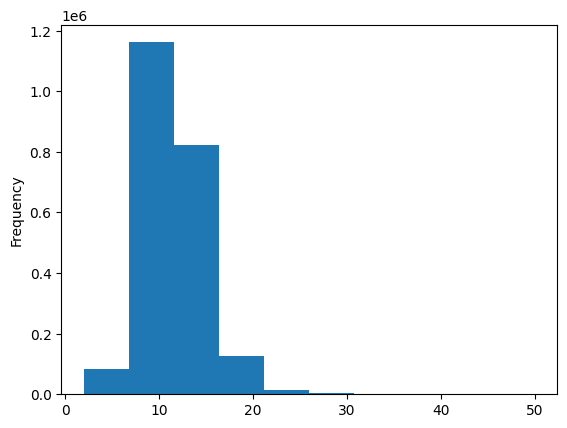

In [12]:
train_df["total_lines"].plot.hist();

In [13]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [14]:
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

In [15]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

C:\Users\rajad\anaconda3\envs\zeus\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [16]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [18]:
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [19]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7497580533665146

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 4, 4, ..., 4, 4, 1])

In [21]:
def calculate_results(y_true, y_pred):
  
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [22]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 74.97580533665146,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146,
 'f1': 0.7389570175489825}

In [23]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

26.229355280462922

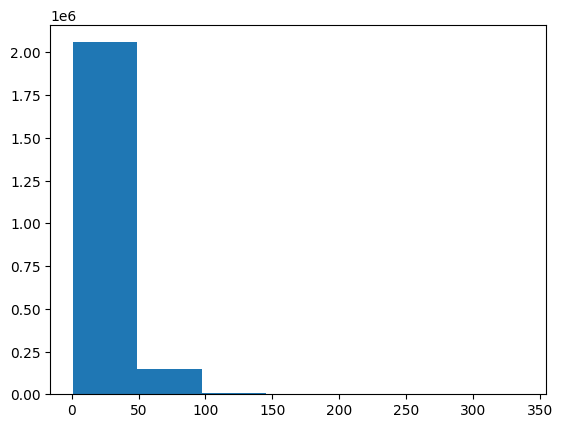

In [24]:

plt.hist(sent_lens, bins=7);

In [25]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

54

In [26]:
max(sent_lens)

338

In [27]:
max_tokens = 68000


In [28]:

text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                    output_sequence_length=55)

In [29]:
text_vectorizer.adapt(train_sentences)

In [30]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the cure-obvious effective rate was @ % in the test group and @ % in the control group ; the total effective rate in them was @ % and @ % respectively , all showing significant difference ( p < @ ) between groups .

Length of text: 45

Vectorized text:
[[   2    1  122   68   10    5    2  121   13    4    5    2   38   13
     2   73  122   68    5 1033   10    4   74   54 1919   33   75   14
    32   23    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [31]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")
     

Number of words in vocabulary: 68000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'and']
Least common words in the vocabulary: ['resite', 'residentmonths', 'rescueeligible', 'rescheduling', 'resc']


In [32]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 68000}

In [33]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), 
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding") 

In [34]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the cure-obvious effective rate was @ % in the test group and @ % in the control group ; the total effective rate in them was @ % and @ % respectively , all showing significant difference ( p < @ ) between groups .

Sentence after vectorization (before embedding):
[[   2    1  122   68   10    5    2  121   13    4    5    2   38   13
     2   73  122   68    5 1033   10    4   74   54 1919   33   75   14
    32   23    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.03913629  0.04924277  0.00185919 ... -0.01666224  0.03163661
    0.0081962 ]
  [-0.01669223 -0.01071256 -0.01190058 ...  0.03465588 -0.02776064
    0.01948423]
  [-0.04472331  0.01855481  0.00408093 ...  0.04840884  0.03116919
   -0.04104555]
  ...
  [ 0.03122368  0.03917411 -0.04309098 ...  0.00105144 -0.02300351
    0.04556862]
  [ 0.03122368  0.03917411 -0.04309098 ...  0.00105144

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [37]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) 
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), 
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
6912/6912 [==============================] - 522s 75ms/step - loss: 0.5895 - accuracy: 0.7886 - val_loss: 0.5072 - val_accuracy: 0.8153
Epoch 2/5
6912/6912 [==============================] - 527s 76ms/step - loss: 0.5028 - accuracy: 0.8223 - val_loss: 0.4725 - val_accuracy: 0.8302
Epoch 3/5
6912/6912 [==============================] - 558s 81ms/step - loss: 0.4812 - accuracy: 0.8298 - val_loss: 0.4571 - val_accuracy: 0.8302
Epoch 4/5
6912/6912 [==============================] - 639s 92ms/step - loss: 0.4677 - accuracy: 0.8340 - val_loss: 0.4427 - val_accuracy: 0.8441
Epoch 5/5
6912/6912 [==============================] - 604s 87ms/step - loss: 0.4633 - accuracy: 0.8367 - val_loss: 0.4492 - val_accuracy: 0.8413


In [40]:
model_1.evaluate(valid_dataset)

905/905 [==============================] - 3s 4ms/step - loss: 0.4479 - accuracy: 0.8397


[0.4479222297668457, 0.8397276401519775]

In [41]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

905/905 [==============================] - 5s 3ms/step


array([[8.3721250e-01, 1.1124255e-03, 7.7925364e-07, 1.6167346e-01,
        7.5384656e-07],
       [1.8796143e-01, 2.7937446e-02, 5.8268619e-01, 7.0733376e-02,
        1.3068151e-01],
       [4.8397554e-04, 5.9255499e-02, 9.1920496e-04, 6.7960282e-05,
        9.3927336e-01],
       ...,
       [1.0988376e-03, 2.6669729e-01, 9.7684373e-05, 2.9550411e-04,
        7.3181063e-01],
       [3.8295459e-02, 5.0073737e-01, 3.5382607e-03, 1.3440025e-02,
        4.4398892e-01],
       [2.8682312e-01, 6.5019083e-01, 1.4323978e-03, 5.7622451e-02,
        3.9311890e-03]], dtype=float32)

In [42]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 1, 1], dtype=int64)>

In [43]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 83.9727637218305,
 'precision': 0.8446038501188402,
 'recall': 0.839727637218305,
 'f1': 0.8390450341875035}

In [44]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")
     

Random training sentence:
changes in the surface width of the wound were affected by the time of scab dehiscence , which varied between volunteers .

Sentence after embedding:
[ 0.02521832  0.04335437  0.03773282 -0.01586264  0.03823829  0.00041192
  0.02722988 -0.01398448  0.00784251  0.07412603  0.07297085  0.0307677
 -0.00937096  0.06552605  0.05484327 -0.00859858  0.05244239 -0.01025042
 -0.03961122  0.04160129 -0.03593137  0.04773725  0.03578191 -0.04852353
  0.04075476  0.06694984 -0.0022993  -0.00166046 -0.05679466 -0.02561479] (truncated output)...

Length of sentence embedding:
512


In [46]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding) 

outputs = layers.Dense(5, activation="softmax")(x) 
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [48]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
6912/6912 [==============================] - 50s 7ms/step - loss: 0.6950 - accuracy: 0.7356 - val_loss: 0.6260 - val_accuracy: 0.7563
Epoch 2/5
6912/6912 [==============================] - 46s 7ms/step - loss: 0.6215 - accuracy: 0.7654 - val_loss: 0.5954 - val_accuracy: 0.7698
Epoch 3/5
6912/6912 [==============================] - 46s 7ms/step - loss: 0.5999 - accuracy: 0.7744 - val_loss: 0.5801 - val_accuracy: 0.7854
Epoch 4/5
6912/6912 [==============================] - 46s 7ms/step - loss: 0.5853 - accuracy: 0.7795 - val_loss: 0.5735 - val_accuracy: 0.7865
Epoch 5/5
6912/6912 [==============================] - 46s 7ms/step - loss: 0.5839 - accuracy: 0.7821 - val_loss: 0.5700 - val_accuracy: 0.7872


In [49]:
model_2.evaluate(valid_dataset)

905/905 [==============================] - 6s 6ms/step - loss: 0.5714 - accuracy: 0.7854


[0.5714365243911743, 0.7853587865829468]

In [50]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

905/905 [==============================] - 6s 6ms/step


array([[8.36507753e-02, 4.23146993e-01, 7.09709004e-02, 3.28189172e-02,
        3.89412403e-01],
       [2.86978632e-02, 6.13801815e-02, 6.47762120e-01, 7.34693110e-02,
        1.88690573e-01],
       [1.86761178e-03, 6.07750379e-02, 3.13262567e-02, 8.54318554e-04,
        9.05176759e-01],
       ...,
       [4.98577999e-03, 5.14903247e-01, 3.12386663e-03, 1.48970517e-03,
        4.75497335e-01],
       [2.72396393e-02, 3.68070066e-01, 1.22405834e-01, 1.27955126e-02,
        4.69488949e-01],
       [1.49041489e-01, 2.68108338e-01, 1.36158033e-03, 5.79221845e-01,
        2.26674066e-03]], dtype=float32)

In [51]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([1, 2, 4, ..., 1, 4, 3], dtype=int64)>

In [52]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results
     

{'accuracy': 78.53587722936541,
 'precision': 0.7813608636765652,
 'recall': 0.7853587722936541,
 'f1': 0.7826243398669447}

In [53]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'c h a n g e s   i n   t h e   s u r f a c e   w i d t h   o f   t h e   w o u n d   w e r e   a f f e c t e d   b y   t h e   t i m e   o f   s c a b   d e h i s c e n c e   ,   w h i c h   v a r i e d   b e t w e e n   v o l u n t e e r s   .'

In [54]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .


In [55]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

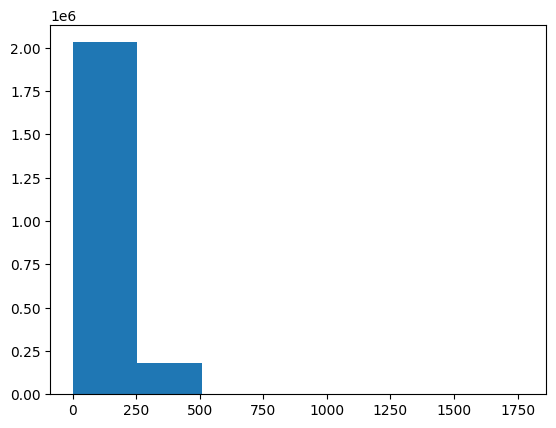

In [56]:
plt.hist(char_lens, bins=7);
     

In [57]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

In [58]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
NUM_CHAR_TOKENS = len(alphabet) + 2 
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [60]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [61]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
s e d a t i v e   e f f e c t s   w e r e   m e a s u r e d   b y   s c o r i n g   p o s t u r e   a n d   r e s p o n s e   t o   n o i s e   .

Length of chars: 62

Vectorized chars:
[[ 9  2 10  4  3  5 21  2  2 17 17  2 12  3  9 20  2  8  2 15  2  4  9 16
   8  2 10 22 19  9 12  7  8  5  6 18 14  7  9  3 16  8  2  4  6 10  8  2
   9 14  7  6  9  2  3  7  6  7  5  9  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [62]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25, 
                              mask_zero=False, 
                              name="char_embed")


print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
s e d a t i v e   e f f e c t s   w e r e   m e a s u r e d   b y   s c o r i n g   p o s t u r e   a n d   r e s p o n s e   t o   n o i s e   .

Embedded chars (after vectorization and embedding):
[[[-0.03961182  0.037233    0.0024109  ... -0.00665523  0.04970297
    0.01026816]
  [ 0.00016295 -0.0340018  -0.00545843 ...  0.01125753  0.02182274
    0.03440107]
  [ 0.04827544  0.02509854 -0.00464831 ... -0.00801356  0.0189135
   -0.00833084]
  ...
  [-0.04557277  0.01314327  0.04716308 ...  0.02025962  0.01429248
    0.00323009]
  [-0.04557277  0.01314327  0.04716308 ...  0.02025962  0.01429248
    0.00323009]
  [-0.04557277  0.01314327  0.04716308 ...  0.02025962  0.01429248
    0.00323009]]]

Character embedding shape: (1, 284, 25)


In [63]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")


model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 284)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 284, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 284, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [65]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [66]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=5,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
6912/6912 [==============================] - 81s 12ms/step - loss: 0.8608 - accuracy: 0.6678 - val_loss: 0.7452 - val_accuracy: 0.7226
Epoch 2/5
6912/6912 [==============================] - 79s 11ms/step - loss: 0.7284 - accuracy: 0.7261 - val_loss: 0.7130 - val_accuracy: 0.7358
Epoch 3/5
6912/6912 [==============================] - 78s 11ms/step - loss: 0.6978 - accuracy: 0.7383 - val_loss: 0.6607 - val_accuracy: 0.7573
Epoch 4/5
6912/6912 [==============================] - 76s 11ms/step - loss: 0.6729 - accuracy: 0.7484 - val_loss: 0.6686 - val_accuracy: 0.7500
Epoch 5/5
6912/6912 [==============================] - 77s 11ms/step - loss: 0.6608 - accuracy: 0.7535 - val_loss: 0.6351 - val_accuracy: 0.7611


In [67]:
model_3.evaluate(val_char_dataset)


905/905 [==============================] - 3s 3ms/step - loss: 0.6463 - accuracy: 0.7592


[0.6463280916213989, 0.7591593861579895]

In [68]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs
     

905/905 [==============================] - 3s 3ms/step


array([[4.49211031e-01, 1.67877540e-01, 1.28781535e-02, 3.52312356e-01,
        1.77208949e-02],
       [3.23292986e-02, 3.11994944e-02, 7.66026020e-01, 3.05148885e-02,
        1.39930218e-01],
       [4.03342536e-04, 1.99502446e-02, 1.35925999e-02, 2.63226771e-04,
        9.65790629e-01],
       ...,
       [1.76151597e-03, 1.54345736e-01, 2.48758169e-03, 1.12338958e-03,
        8.40281785e-01],
       [1.21139120e-02, 3.65936995e-01, 1.82537246e-03, 7.15889409e-03,
        6.12964869e-01],
       [1.86068460e-01, 7.36444831e-01, 9.37012956e-03, 5.72282635e-02,
        1.08882934e-02]], dtype=float32)

In [69]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1], dtype=int64)>

In [70]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 75.91594082676622,
 'precision': 0.757254610535101,
 'recall': 0.7591594082676622,
 'f1': 0.7542794522460309}

In [71]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [72]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [73]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])
     

In [74]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [75]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [76]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
6912/6912 [==============================] - 366s 52ms/step - loss: 0.7241 - accuracy: 0.7259 - val_loss: 0.6065 - val_accuracy: 0.7677
Epoch 2/5
6912/6912 [==============================] - 413s 60ms/step - loss: 0.6582 - accuracy: 0.7533 - val_loss: 0.5788 - val_accuracy: 0.7691
Epoch 3/5
6912/6912 [==============================] - 411s 59ms/step - loss: 0.6400 - accuracy: 0.7600 - val_loss: 0.5581 - val_accuracy: 0.7937
Epoch 4/5
6912/6912 [==============================] - 425s 62ms/step - loss: 0.6247 - accuracy: 0.7677 - val_loss: 0.5522 - val_accuracy: 0.7889
Epoch 5/5
6912/6912 [==============================] - 418s 60ms/step - loss: 0.6236 - accuracy: 0.7690 - val_loss: 0.5478 - val_accuracy: 0.7920


In [77]:
model_4.evaluate(val_char_token_dataset)

905/905 [==============================] - 17s 19ms/step - loss: 0.5550 - accuracy: 0.7927


[0.5550006031990051, 0.7926862835884094]

In [78]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

905/905 [==============================] - 18s 19ms/step


array([[0.1711127 , 0.40268213, 0.03006789, 0.05749226, 0.338645  ],
       [0.02913352, 0.00886468, 0.82769805, 0.03068502, 0.10361872],
       [0.00380697, 0.15871039, 0.01587086, 0.00103696, 0.8205749 ],
       ...,
       [0.06611161, 0.59749025, 0.00968956, 0.02782496, 0.29888365],
       [0.2556578 , 0.2483366 , 0.08470038, 0.17445895, 0.2368463 ],
       [0.14688301, 0.7918344 , 0.00277369, 0.04521828, 0.01329059]],
      dtype=float32)

In [79]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([1, 2, 4, ..., 1, 0, 1], dtype=int64)>

In [80]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 79.26862989077837,
 'precision': 0.7911202336354439,
 'recall': 0.7926862989077837,
 'f1': 0.7893273375680551}

In [81]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


In [82]:
train_df["line_number"].value_counts()

line_number
0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

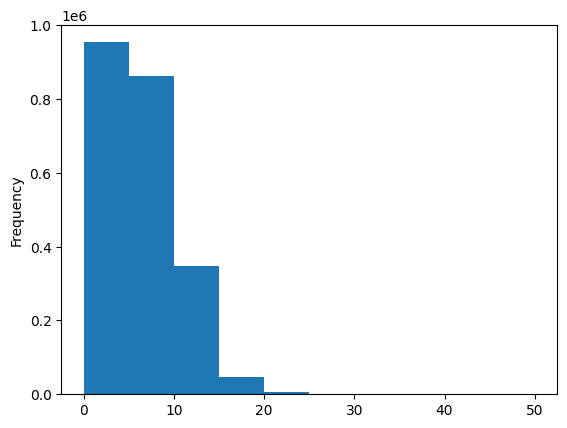

In [83]:
train_df.line_number.plot.hist()

In [84]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
     

In [85]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([2211861, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

In [86]:
train_df["total_lines"].value_counts()

total_lines
10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: count, dtype: int64

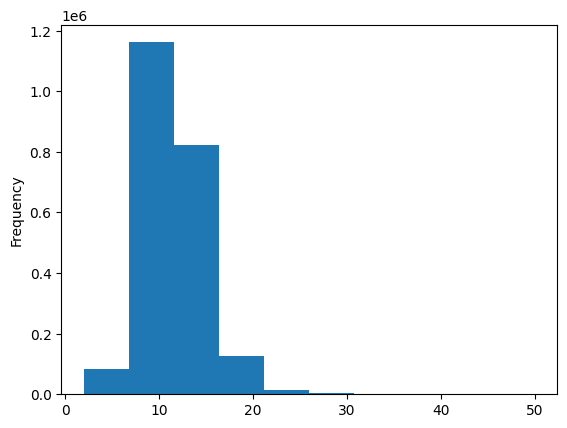

In [87]:
train_df.total_lines.plot.hist();


In [88]:
np.percentile(train_df.total_lines, 98)

20.0

In [89]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([2211861, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

In [90]:
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [91]:
model_5.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [92]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001E27D1E34F0> True
<keras.engine.input_layer.InputLayer object at 0x000001E27D1FC2B0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001E166416A00> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x000001E15F6AED90> False
<keras.layers.core.embedding.Embedding object at 0x000001E29B16A430> True
<keras.layers.core.dense.Dense object at 0x000001E27D22B400> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x000001E27D29BEB0> True
<keras.layers.merging.concatenate.Concatenate object at 0x000001E27D279E50> True
<keras.engine.input_layer.InputLayer object at 0x000001E27D22A100> True
<keras.engine.input_layer.InputLayer object at 0x000001E27C305FD0> True
<keras.layers.core.dense.Dense object at 0x000001E27E9814F0> True
<keras.layers.core.dense.Dense object at 0x000001E16686B4C0> True
<keras.layers.core.dense.Dense object at 0x000001E27C2A7490> True
<keras.layers.regularization.dropout.

In [93]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [94]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences,
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [95]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/5
6912/6912 [==============================] - 419s 60ms/step - loss: 0.9400 - accuracy: 0.8295 - val_loss: 0.9079 - val_accuracy: 0.8580
Epoch 2/5
6912/6912 [==============================] - 409s 59ms/step - loss: 0.9063 - accuracy: 0.8534 - val_loss: 0.8938 - val_accuracy: 0.8663
Epoch 3/5
6912/6912 [==============================] - 408s 59ms/step - loss: 0.9009 - accuracy: 0.8568 - val_loss: 0.8870 - val_accuracy: 0.8674
Epoch 4/5
6912/6912 [==============================] - 409s 59ms/step - loss: 0.8955 - accuracy: 0.8607 - val_loss: 0.8862 - val_accuracy: 0.8687
Epoch 5/5
6912/6912 [==============================] - 409s 59ms/step - loss: 0.8943 - accuracy: 0.8620 - val_loss: 0.8874 - val_accuracy: 0.8681


In [96]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

905/905 [==============================] - 17s 18ms/step


array([[0.45976326, 0.05418292, 0.03184936, 0.3103574 , 0.14384703],
       [0.16477975, 0.03425394, 0.5911968 , 0.14625968, 0.06350986],
       [0.1735511 , 0.05709676, 0.1706531 , 0.13333458, 0.46536443],
       ...,
       [0.05439234, 0.42919976, 0.06740939, 0.05839933, 0.39059922],
       [0.03452731, 0.49036074, 0.08845798, 0.0492328 , 0.33742115],
       [0.05701174, 0.7988164 , 0.03673995, 0.02651251, 0.08091941]],
      dtype=float32)

In [97]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 1, 1, 1], dtype=int64)>

In [98]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 86.80353933360985,
 'precision': 0.8701537167468887,
 'recall': 0.8680353933360985,
 'f1': 0.8666121579935188}

In [99]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results
     

,accuracy,precision,recall,f1
baseline,74.975805,0.743197,0.749758,0.738957
custom_token_embed_conv1d,83.972764,0.844604,0.839728,0.839045
pretrained_token_embed,78.535877,0.781361,0.785359,0.782624
custom_char_embed_conv1d,75.915941,0.757255,0.759159,0.754279
hybrid_char_token_embed,79.268630,0.791120,0.792686,0.789327
tribrid_pos_char_token_embed,86.803539,0.870154,0.868035,0.866612


In [100]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

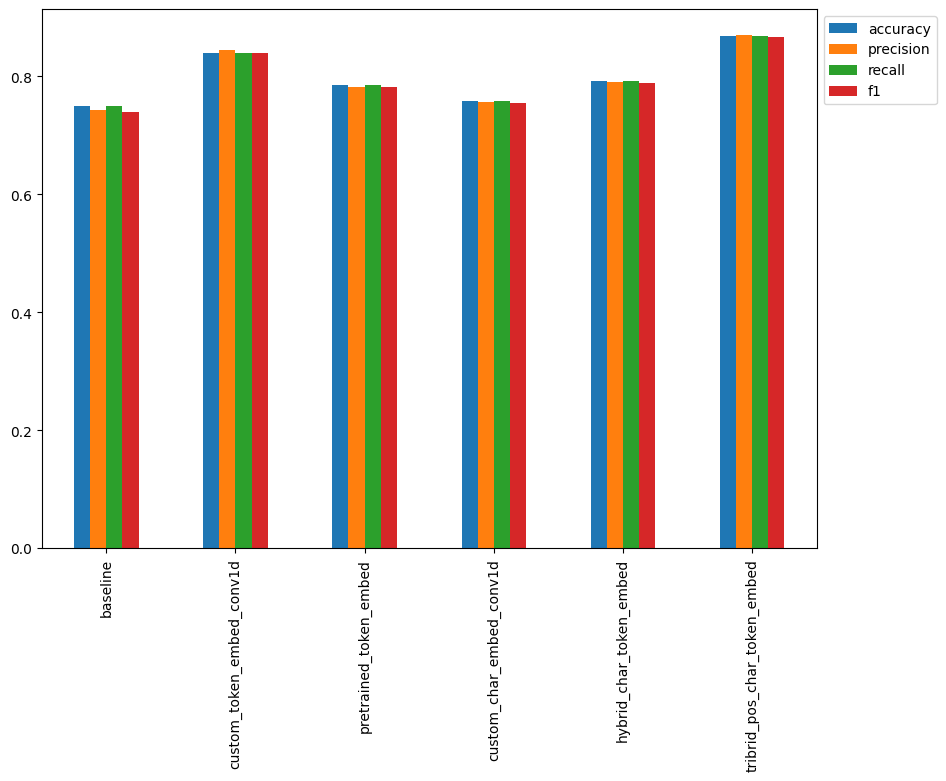

In [101]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));
     

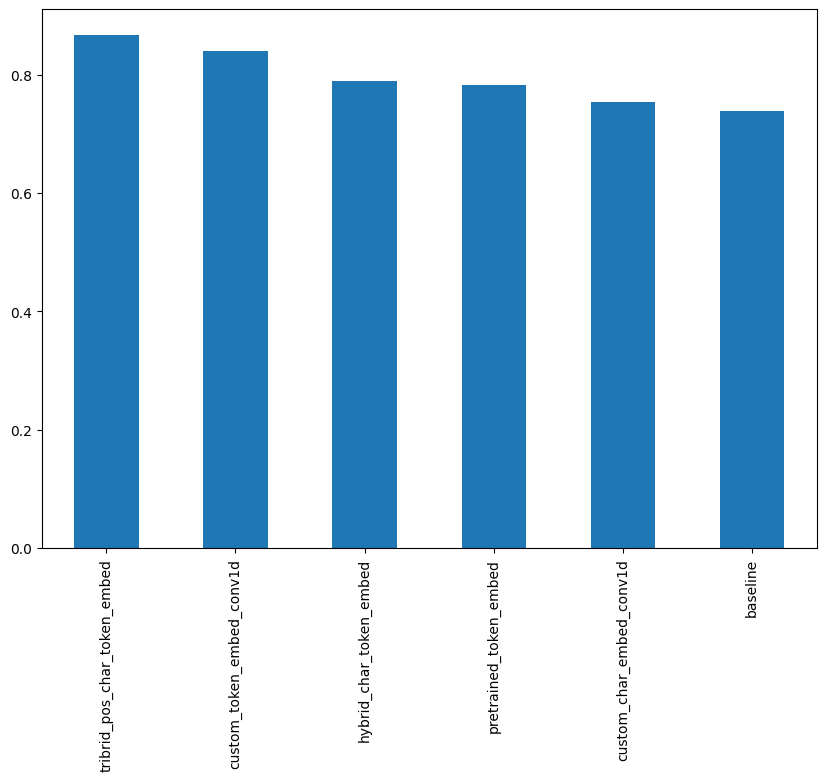

In [102]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [103]:
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


In [104]:
model_path = "skimlit_tribrid_model/"

In [105]:
loaded_model = tf.keras.models.load_model(model_path)

In [106]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

905/905 [==============================] - 17s 18ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 4, 4, 4, 4, 4, 4, 1, 3], dtype=int64)>

In [107]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 86.80353933360985,
 'precision': 0.8701537167468887,
 'recall': 0.8680353933360985,
 'f1': 0.8666121579935188}

In [108]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [109]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [110]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [111]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

922/922 [==============================] - 17s 18ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 2, 2, 4, 2, 2, 4, 4, 4], dtype=int64)>

In [112]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 86.61038212457193,
 'precision': 0.8673330551503142,
 'recall': 0.8661038212457193,
 'f1': 0.8646432337528045}

In [113]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKG

In [114]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10,BACKGROUND,0.552425,True
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10,BACKGROUND,0.524564,True
2,BACKGROUND,"in the present study , we examined the associa...",2,10,METHODS,0.401997,False
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10,METHODS,0.445364,False
4,METHODS,a total of @ mi patients and @ control persons...,4,10,RESULTS,0.560353,False
5,METHODS,plasma samples were obtained and analysed with...,5,10,METHODS,0.826442,True
6,METHODS,the myocardial outcomes ( salvage index and fi...,6,10,METHODS,0.574813,True
7,RESULTS,mi patients had @ % higher plasma levels of ma...,7,10,RESULTS,0.864123,True
8,RESULTS,"however , neither salvage index ( spearman rho...",8,10,RESULTS,0.856179,True
9,RESULTS,"likewise , masp-@ and masp-@ were elevated in ...",9,10,RESULTS,0.792208,True


In [115]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13239,CONCLUSIONS,isrctn@ . ),14,14,BACKGROUND,0.964748,False
1728,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.911199,False
19062,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,21,21,BACKGROUND,0.907849,False
25542,METHODS,this study provides class i evidence that trea...,10,10,CONCLUSIONS,0.906294,False
21480,CONCLUSIONS,nct @ .,12,12,BACKGROUND,0.901092,False
...,...,...,...,...,...,...,...
17136,RESULTS,estimated glomerular filtration rate ( egfr ) ...,4,13,METHODS,0.824200,False
16031,CONCLUSIONS,morbidity did not differ significantly between...,8,10,RESULTS,0.823304,False
343,RESULTS,blood samples were collected weekly to determi...,5,12,METHODS,0.822745,False
29424,METHODS,women who attended the workshop had higher sel...,7,9,RESULTS,0.821274,False


In [116]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.964748203754425, Line number: 14, Total lines: 14

Text:
isrctn@ . )

-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9111994504928589, Line number: 4, Total lines: 20

Text:
the national institute of oncology , budapest conducted a single centre randomized clinical study .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9078488945960999, Line number: 21, Total lines: 21

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: METHODS, Pred: CONCLUSIONS, Prob: 0.9062935709953308, Line number: 10, Total lines: 10

Text:
this study provides class i evidence that treatment with ptx does not prevent deterioration in muscle function or strength in corticosteroid-treated boys with dmd .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9010918140411377, Line number: 12, Total lines: 12

Text:
nct @ .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.8995391130447388, Line number: 11, Total lines: 11

Text:
nct@ .

-----

T

In [117]:

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [118]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [119]:
nlp = English() 
sentencizer = nlp.add_pipe("sentencizer") 

doc = nlp(example_abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] 
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [120]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [121]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [122]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [123]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [124]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 793ms/step


array([[0.411246  , 0.09544836, 0.03038481, 0.4310504 , 0.03187048],
       [0.1165657 , 0.05061393, 0.67171377, 0.09529336, 0.06581327],
       [0.15899692, 0.08113102, 0.5319546 , 0.1049456 , 0.12297193],
       [0.10670484, 0.19568117, 0.4487402 , 0.09392084, 0.1549529 ],
       [0.0568205 , 0.0861894 , 0.16360053, 0.03739789, 0.6559917 ],
       [0.0492874 , 0.08254141, 0.41260424, 0.03940434, 0.4161626 ],
       [0.02499993, 0.19201203, 0.08336158, 0.02337569, 0.67625076],
       [0.0203098 , 0.15038548, 0.12692265, 0.02301665, 0.6793654 ]],
      dtype=float32)

In [125]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds
     

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 4], dtype=int64)>

In [126]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [127]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
